## Import modules

In [1]:
from common_dirs_fns import *
from sort_seq_functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Specify matplotlib formatting
%matplotlib inline
mpl.rcParams['svg.fonttype']='none'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['axes.linewidth'] = 1.
mpl.rcParams['mathtext.default'] = 'regular'
plt.rcParams.update({'font.size': 10})

## Import sort-seq data and bootstrap data

In [3]:
# This dataframe contains the sort-seq fit data for the real dataset
stats_table = pd.read_csv(analysis_path+'stats_table.csv', index_col=[0], header=[0], na_filter=False)

# This dataframe contains information about the read counts for the real dataset
tln_count_df_processed = rename_unnamed(pd.read_csv(analysis_path+'tln_count_df_processed.csv',
                                                    index_col=[0],
                                                    header=[0,1],
                                                    na_filter=False))

# TotalReads represents the total number of NGS reads in Bins 1 through 8
stats_table['TotalReads'] = tln_count_df_processed.loc[stats_table.index,'TotalReads']

In [4]:
# This is the summary information for the bootstrap data, which contains
# medians and 5th and 95th percentile information for peptide fluorescence means
# and fold changes
bootstrap_summary = rename_unnamed(pd.read_csv(analysis_path+'bootstrap_summary.csv',
                                               index_col=[0], header=[0,1], na_filter=False))

# Reindex the bootstrap summary table to include only those peptides with > 10 reads
# (across Bins 1 through 8) in the real dataset
bootstrap_summary_st = bootstrap_summary.reindex(stats_table.index)

In [5]:
# Empty string represents any sequences that did not have a stop codon
# Do not include this in the analysis because it represents
# a diverse grouping of sequences which may not display peptides
peptide_idx = ~stats_table.index.isin([''])

stats_table = stats_table.loc[peptide_idx]
bootstrap_summary_st = bootstrap_summary_st.loc[peptide_idx]

## Plot 5th-95th percentile intervals for each peptide

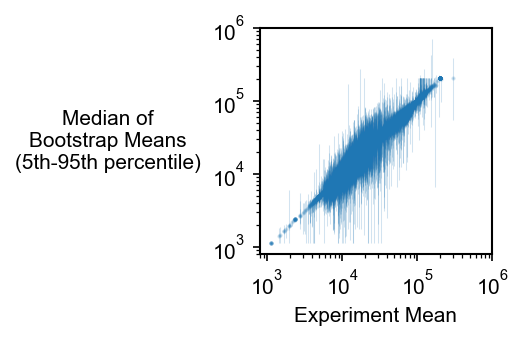

In [6]:
fig = plt.figure(figsize=(2,2),dpi=150)
ax = plt.subplot()

plt.errorbar(stats_table['Mean_Simple'],
            bootstrap_summary_st[('Mean','Median')],
            yerr=bootstrap_summary_st[[('Mean','Pct5'),('Mean','Pct95')]].subtract(
                 bootstrap_summary_st[('Mean','Median')], axis=0).abs().transpose().values,
            linestyle='',marker='.',alpha=0.2,markersize=2,linewidth=0.5)

plt.yscale('log')
plt.xscale('log')

# Set major and minor tick locations on the x axis so that they match the default y axis
ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10,numticks=12))
ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,numticks=12,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)))
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

plt.ylim([800,10**6])
plt.xlim([800,10**6])

plt.ylabel('Median of\nBootstrap Means\n(5th-95th percentile)',rotation=0,verticalalignment='center',labelpad=50)
plt.xlabel('Experiment Mean')
plt.savefig(figures_path+'dataMeans_vs_bootstrapMeans.png',dpi=300,bbox_inches='tight')

## Calculate the normalized width of the bootstrap 5th-95th percentile range for distribution statistics

In [7]:
# Divide the 5th-95th percentile range by the real value for each metric to normalize

for metric in bootstrap_summary_st.columns.levels[0]:
    # Use try-except to catch any metrics that do not have calculated 5th/95th percentiles (e.g., N_Iter)
    try:
        bootstrap_summary_st.loc[:,(metric,'Pct5_Pct95_Width')] = (bootstrap_summary_st.loc[:, (metric,'Pct95')]
                                                                 - bootstrap_summary_st.loc[:, (metric,'Pct5')]).div(
                                                                            stats_table.loc[:, metric+'_Simple'])
    except:
        None

bootstrap_summary_st = bootstrap_summary_st.sort_index(axis=1)

## Determine which peptides to exclude based on poor NGS quality

In [8]:
# Set empirically-determined quality thresholds

max_pct_range = 0.4 # Maximum normalized 5th-95th percentile range
min_reads = 100 # Minimum total reads in Bins 1-8

# Determine which peptides to keep for downstream analysis based on quality thresholds
to_keep = (stats_table['TotalReads']>min_reads)&(bootstrap_summary_st[('Mean','Pct5_Pct95_Width')]<max_pct_range)

In [9]:
# Print number of peptides retained after implementing quality thresholds

print('\t\t'.join(['Number of peptides matching minimum read criteria ('+str(min_reads)+' reads):',
      str(len(stats_table[(stats_table['TotalReads']>min_reads)])),
      '{:.2%}'.format(len(stats_table[(stats_table['TotalReads']>min_reads)])/len(stats_table))]))

print('\t\t'.join(['Number of peptides matching maximum normalized\n\t\t'
                   +'5th-95th percentile range criteria ('+str(max_pct_range)+'):',
      str(len(stats_table[(bootstrap_summary_st[('Mean','Pct5_Pct95_Width')]<max_pct_range)])),
      '{:.2%}'.format(len(stats_table[(bootstrap_summary_st[('Mean','Pct5_Pct95_Width')]<max_pct_range)])/len(stats_table))]))

print('\t\t'.join(['Number of peptides matching both criteria:\t\t',
      str(len(stats_table[to_keep])),
      '{:.2%}'.format(len(stats_table[to_keep])/len(stats_table))]))

Number of peptides matching minimum read criteria (100 reads):		4056		29.73%
Number of peptides matching maximum normalized
		5th-95th percentile range criteria (0.4):		7488		54.89%
Number of peptides matching both criteria:				3903		28.61%


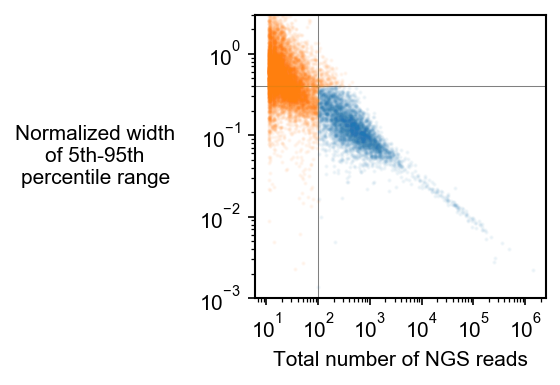

In [10]:
# Superimpose thresholds and data

plt.figure(figsize=(2.5,2.5),dpi=150)
ax = plt.subplot()

# Plot populations to discard and to keep
ax.plot(stats_table.loc[~to_keep, 'TotalReads'],
        bootstrap_summary_st.loc[~to_keep, ('Mean','Pct5_Pct95_Width')],
        linestyle='',marker='.', alpha=0.05, markersize=2, color='C1')
ax.plot(stats_table.loc[to_keep, 'TotalReads'],
        bootstrap_summary_st.loc[to_keep, ('Mean','Pct5_Pct95_Width')],
        linestyle='',marker='.', alpha=0.05, markersize=2, color='C0')

# Plot threshold values
ax.axvline(min_reads, color='grey', linewidth=0.5, zorder=-1)
ax.axhline(max_pct_range, color='grey', linewidth=0.5, zorder=-1)

# Set axis scales and limits
plt.xscale('log')
plt.yscale('log')
plt.ylim([10**-3,3])

# Set major and minor ticks for x axis
ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10,numticks=12))
ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,numticks=12,subs=np.arange(0.1,1.,0.1)))
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# Set axis labels
plt.xlabel('Total number of NGS reads')
plt.ylabel('Normalized width\nof 5th-95th\npercentile range',rotation=0,verticalalignment='center',labelpad=50)

plt.savefig(figures_path+'TotalReads_vs_PctRange'+'.png',bbox_inches='tight')

## Plot fluorescence and fold change distributions of peptides with good NGS quality

The fold change for the autofluorescence control was calculated using actual flow cytometry measurements comparing an mNeonGreen-negative population to a no peptide control (see FACS_data notebook). Because the no peptide control mean calculated using flow cytometry is slightly different from the no peptide control mean calculated using sort-seq, the autofluorescence values fall at slightly different locations in the mean and fold change plots below.

Peptides that have a calculated fold change value less than the autofluorescence fold change will be eliminated from future analyses, as these constructs likely have mutations in mNeonGreen that render them non-fluorescent. Autofluorescence fold change is slightly more restrictive than autofluorescence mean (see explanation above) and removes an additional 54 peptides from consideration. This small reduction in peptide quantity is acceptable to ensure that peptides lacking a functional copy of mNeonGreen are removed.

In [11]:
stats_table_hq = stats_table.loc[to_keep]
bootstrap_summary_st_hq = bootstrap_summary_st.loc[to_keep]

In [12]:
autofl_df = pd.read_csv(analysis_path+'autofluorescence.csv', index_col=0, header=0)

In [13]:
auto_mean = autofl_df.loc['Mean','Value']
print('\t\t'.join(['Number of peptides with fluorescence mean > autofluorescence:\t',
      str(len(stats_table_hq[(stats_table_hq['Mean_Simple']>auto_mean)])),
      '{:.2%}'.format(len(stats_table_hq[(stats_table_hq['Mean_Simple']>auto_mean)])/len(stats_table_hq))]))

auto_fc = autofl_df.loc['Fold Change','Value']
print('\t\t'.join(['Number of peptides with fluorescence fold change > autofluorescence:',
      str(len(stats_table_hq[(stats_table_hq['Fold Change_Simple']>auto_fc)])),
      '{:.2%}'.format(len(stats_table_hq[(stats_table_hq['Fold Change_Simple']>auto_fc)])/len(stats_table_hq))]))

for fc in [1., 2., 5., 10.]:
    print('\t\t'.join(['Number of peptides with > '+'{:.0f}'.format(fc)+'-fold activation:\t\t\t',
          str(len(stats_table_hq[(stats_table_hq['Fold Change_Simple']>fc)])),
          '{:.2%}'.format(len(stats_table_hq[(stats_table_hq['Fold Change_Simple']>fc)])/len(stats_table_hq))]))

Number of peptides with fluorescence mean > autofluorescence:			3860		98.90%
Number of peptides with fluorescence fold change > autofluorescence:		3798		97.31%
Number of peptides with > 1-fold activation:					2245		57.52%
Number of peptides with > 2-fold activation:					510		13.07%
Number of peptides with > 5-fold activation:					268		6.87%
Number of peptides with > 10-fold activation:					55		1.41%


### Histogram of peptide fold change and fluorescence values

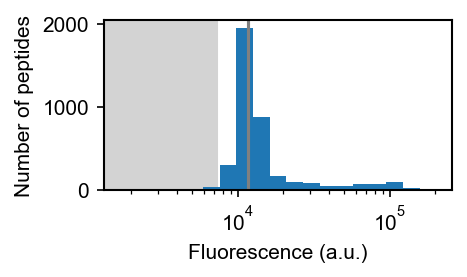

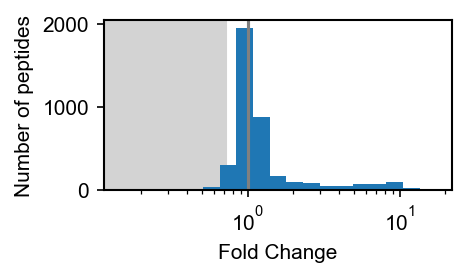

In [14]:
for metric, xlabel in zip(['Mean','Fold Change'],['Fluorescence (a.u.)','Fold Change']):

    fig = plt.figure(figsize=(3,1.5),dpi=150)

    xlim = [stats_table_hq[metric+'_Simple'].min(),
            stats_table_hq[metric+'_Simple'].max()]
    
    bins = np.logspace(np.log10(xlim[0]),np.log10(xlim[1]),20)
    
    plt.hist(stats_table_hq.loc[(~stats_table_hq.index.isin(['','*']))][metric+'_Simple'], bins=bins)
    plt.axvline(stats_table_hq.loc[stats_table_hq.index=='*',metric+'_Simple'].values[0],color='grey')
    plt.axvspan(plt.xlim()[0], autofl_df.loc[metric,'Value'], zorder=-1, color='lightgrey')
    plt.xscale('log')

    plt.xlabel(xlabel)
    plt.ylabel('Number of peptides')
    
    plt.savefig(figures_path+metric+'_distribution_clean.png',bbox_inches='tight',dpi=300)

### Rank-ordered fold change and fluorescence

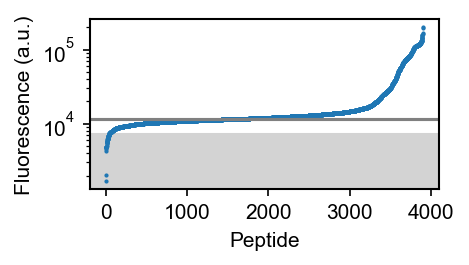

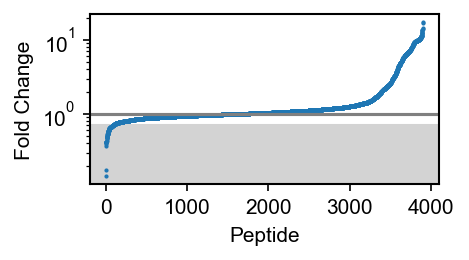

In [15]:
for metric,xlabel in zip(['Mean','Fold Change'],['Fluorescence (a.u.)','Fold Change']):

    fig = plt.figure(figsize=(3,1.5),dpi=150)

    xlim = [stats_table_hq[metric+'_Simple'].min(),
            stats_table_hq[metric+'_Simple'].max()]
    
    bins = np.logspace(np.log10(xlim[0]),np.log10(xlim[1]),20)
    
    plt.plot(np.arange(len(stats_table_hq.loc[(~stats_table_hq.index.isin(['','*']))])),
             stats_table_hq.loc[(~stats_table_hq.index.isin(['','*']))].sort_values(metric+'_Simple')[metric+'_Simple'],
             linestyle='', marker='.', markersize=2)
    
    plt.axhline(stats_table_hq.loc[stats_table_hq.index=='*',metric+'_Simple'].values[0], color='grey')
    
    plt.axhspan(plt.ylim()[0], autofl_df.loc[metric,'Value'], color='lightgrey', zorder=-1)
    
    plt.ylabel(xlabel)
    plt.xlabel('Peptide')
    plt.yscale('log')
    plt.savefig(figures_path+metric+'_distribution_dots_clean.png',bbox_inches='tight',dpi=300)

In [16]:
# Save peptides with fold changes > autofluorescence to a separate file for future analysis
fc_pass = stats_table_hq['Fold Change_Simple']>autofl_df.loc['Fold Change','Value']
stats_table_hq.loc[fc_pass].to_csv(analysis_path+'stats_table_clean.csv')
bootstrap_summary_st_hq.loc[fc_pass].to_csv(analysis_path+'bootstrap_summary_clean.csv')

## Save cleaned sort-seq results to a CSV

In [17]:
sort_seq_results = stats_table_hq.loc[fc_pass, ['Fold Change_Simple', 'TotalReads']]
sort_seq_results = sort_seq_results.rename({'Fold Change_Simple':'Fold Change',
                         'TotalReads':'Total Read Count'}, axis=1)
sort_seq_results.columns = pd.MultiIndex.from_tuples([('Fold Change', ''), ('Total Read Count', '')])

In [18]:
for metric in ['Count', 'Frequency', 'NormWtd']:
    sort_seq_results = pd.concat([sort_seq_results, tln_count_df_processed[mixed_stats_bins.index].reindex(
                sort_seq_results.index).swaplevel(axis=1).sort_index(axis=1)[[metric]]], axis=1)

In [19]:
sort_seq_results = sort_seq_results.rename({'NormWtd':'Weighted Frequency'}, level=0, axis=1)

In [20]:
sort_seq_results.to_csv(analysis_path+'sort-seq_results_processed.csv')
sort_seq_results.to_excel(analysis_path+'sort-seq_results_processed.xlsx')